# Peak Model Visualisations for States

In [1]:
import altair as alt
from matplotlib.pylab import plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import matplotlib.dates as mdates



import pandas as pd
import numpy as np

import seaborn as sns
import altair as alt

import datetime 

alt.data_transformers.disable_max_rows()

%matplotlib inline

# Parameters

In [2]:
peak_model_dataset = '../data/processed/peak_models_for_states.csv'

# The Dataset

In [3]:
df = pd.read_csv(peak_model_dataset, parse_dates=['date'])
df.shape

(6391, 28)

In [4]:
df['state'].nunique()

51

# Combination Model

## Visualising a Single Country/Region

In [5]:
def plot_growth(ax, data, peak_label='cases/day', **kwargs):

    peak_date, peak_value = data.idxmax(), data.max()
    
    current_week, prev_week = data[-7:].sum(), data[-14:-7].sum()
    
    rel = data/peak_value
    
    # Plot the growth line
    ax.plot(rel.index, rel, lw=2, c='k')
    ax.fill_between(rel.index, 0, rel, color='whitesmoke')
    
    # Highlight and label the end point
    end_date, end_value = rel.index[-1], rel[-1]
    
    end_pct = int(100*end_value)
    end_text = '<1%' if end_pct<1 else '  {}%'.format(end_pct)
    end_text = end_text+'↑' if current_week>prev_week else end_text+'↓'
    
    ax.plot(end_date, end_value, marker='o', markersize=3, c='k')
    
    end_value_y_adj = -.05 if end_value>0.1 else 0.05
    ax.text(end_date, end_value+end_value_y_adj, '{}'.format(end_text), color='dimgrey', ha='left', **kwargs)

    # Highlight and label the peak
    ax.plot(peak_date, 1, marker='o', markersize=6, c='r')
    ax.plot(peak_date, 1, marker='o', markersize=1, c='k')
    
    if peak_value < 1:
        peak_value_text = '<1'
    else:
        peak_value_text = '~{:,}k'.format(round(peak_value/1000, 1)) if peak_value>999 else '~{:,}'.format(int(peak_value))

    ha = 'left' if peak_date<datetime.datetime.strptime('01/05/2020', "%d/%m/%Y") else 'right'
    ax.text(peak_date, 1.075, ' {}\n {}'.format(peak_value_text, peak_label), color='dimgrey', ha=ha, **kwargs)

        

    return rel

In [6]:
def plot_lockdown(ax, lockdown, h=.25, bottom=0, title='', **kwargs):
    
    # The colour map
    transition_colours = ['white', 'skyblue', 'yellow', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("", transition_colours)

    # Current and last week's values
    current_week, prev_week = lockdown[-7:].sum(), lockdown[-14:-7].sum()

    # Normalise lockdown & assign colours
    rel = lockdown/100
    colours = [cmap(v) for v in rel.values]


    # Plot the bars
    ax.bar(rel.index, [h]*len(rel.index), bottom=bottom, width=2, color=colours)
    
    # Plot the trace
    ax.plot(rel.index, (rel*h)+bottom, lw=1, c='dimgrey')
    
    # Label the current status
    label_x = ax.get_xlim()[1]
    label_y = (rel[-1]*h)+bottom
    label = int(rel[-1]*100)
    arrow = '↑' if current_week>prev_week else '↓'
    
    ax.annotate('{:,}%{}'.format(label, arrow), xy=(label_x, label_y), color='dimgrey', **kwargs)
    
    ax.plot(rel.index[-1], label_y, marker='o', markersize=3, c='k')
    
    # Label the lockdown chart
    ax.text(ax.get_xlim()[0], bottom+.1, '{} ({:,}%/d)'.format(title, int(lockdown.mean())), color='dimgrey', **kwargs)


    

In [7]:
def plot_stages(ax, growth_data, stages, **kwargs):
    
    peak_value = growth_data.max()
    
    # Add the growth stages
    stage_start_dates = stages.reset_index().groupby(
        stages.reset_index().columns[1]).first().reindex(['E', 'P', 'C', 'S']).dropna()

    stage_start_dates['date'].map(
        lambda start_date: ax.plot([start_date]*2, [0, growth_data[start_date]/peak_value], lw=.25, c='k'))

In [8]:
def plot_annotations(ax, title, total_cases, total_deaths, **kwargs):
    
    # The title
    ax.set_title('{}\n{:,} cases/M, {:,} deaths/M\nCFR ~ {}'.format(
        title, 
        int(total_cases), 
        int(total_deaths),
        round(total_deaths/total_cases, 3)
    ), loc='left', fontsize=int(kwargs['fontsize']*1))
    
    # x-axis date locators and formatters
    locator = mdates.AutoDateLocator(maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    
    # Remove the axes spines and the y ticks
    [s.set_visible(False) for s in ax.spines.values()]
    [t.set_visible(False) for t in ax.get_yticklines()]
    [t.set_visible(False) for t in ax.get_yticklabels()]

    ax.spines['bottom'].set_visible(True)


    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    month_fmt = mdates.DateFormatter('%b')
    def m_fmt(x, pos=None):
        return month_fmt(x)[:3]

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))
        
    ax.tick_params(axis = 'x', which = 'major', width=1, length=5, labelsize=kwargs['fontsize'], labelcolor='dimgrey', color='dimgrey')


In [22]:
def plot_peak_lockdown_model(
    ax, df, 
    growth_col='new_cases_rolling_mean', 
    mobility_col='google_rolling_mobility_drop', 
    stringency_col='stringency_index', 
    **kwargs
):
    start_date, end_date = datetime.date(2020, 1, 1), datetime.datetime.today()
    
    ax.set_xlim(start_date, end_date)
    
    
    total_cases_per_million = df['total_cases_per_million'].max()
    total_deaths_per_million = df['total_deaths_per_million'].max()

    
    stage_col = growth_col+'_stage'

    growth_data = df[growth_col].ffill()
    
    mobility_data = df[mobility_col].ffill()
    stage_data = df[stage_col].ffill()
    
    plot_growth(ax, growth_data, **kwargs)
    plot_stages(ax, growth_data, stage_data, **kwargs)

    bx = ax.twinx()
    if mobility_data.notnull().any(): plot_lockdown(bx, mobility_data, bottom=0, h=.2, title='MD', **kwargs)
    
    
    ax.set_ylim(-.4, 1.4)
    bx.set_ylim(0, 1)

    bx.axis('off')
    
    pop = int(df.iloc[0]['population']//1000000)
    country_title = '{} (p.{}M)'.format(df.iloc[0]['state'], '<1' if pop <1 else '~'+str(pop))

    plot_annotations(ax, country_title, total_cases_per_million, total_deaths_per_million, **kwargs)
    
    return
    
    
    

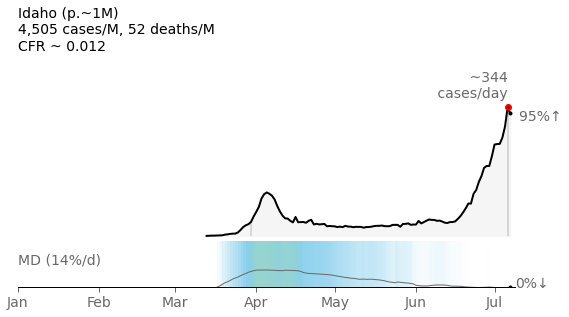

In [23]:
sns.set_context('paper')

fig, ax = plt.subplots(figsize=(8, 4.5))

state = 'Idaho'

data = df[df['state']==state].set_index('date')

plot_peak_lockdown_model(ax, data, growth_col='new_cases_rolling_mean', fontsize=14)


fig.tight_layout()

# All States

In [24]:
current_cases_per_day = df.groupby('state')['new_cases_per_million_rolling_mean'].last()

sorted_states = sorted(df.state.unique(), key=lambda c: current_cases_per_day[c], reverse=True)
len(sorted_states)

51

/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


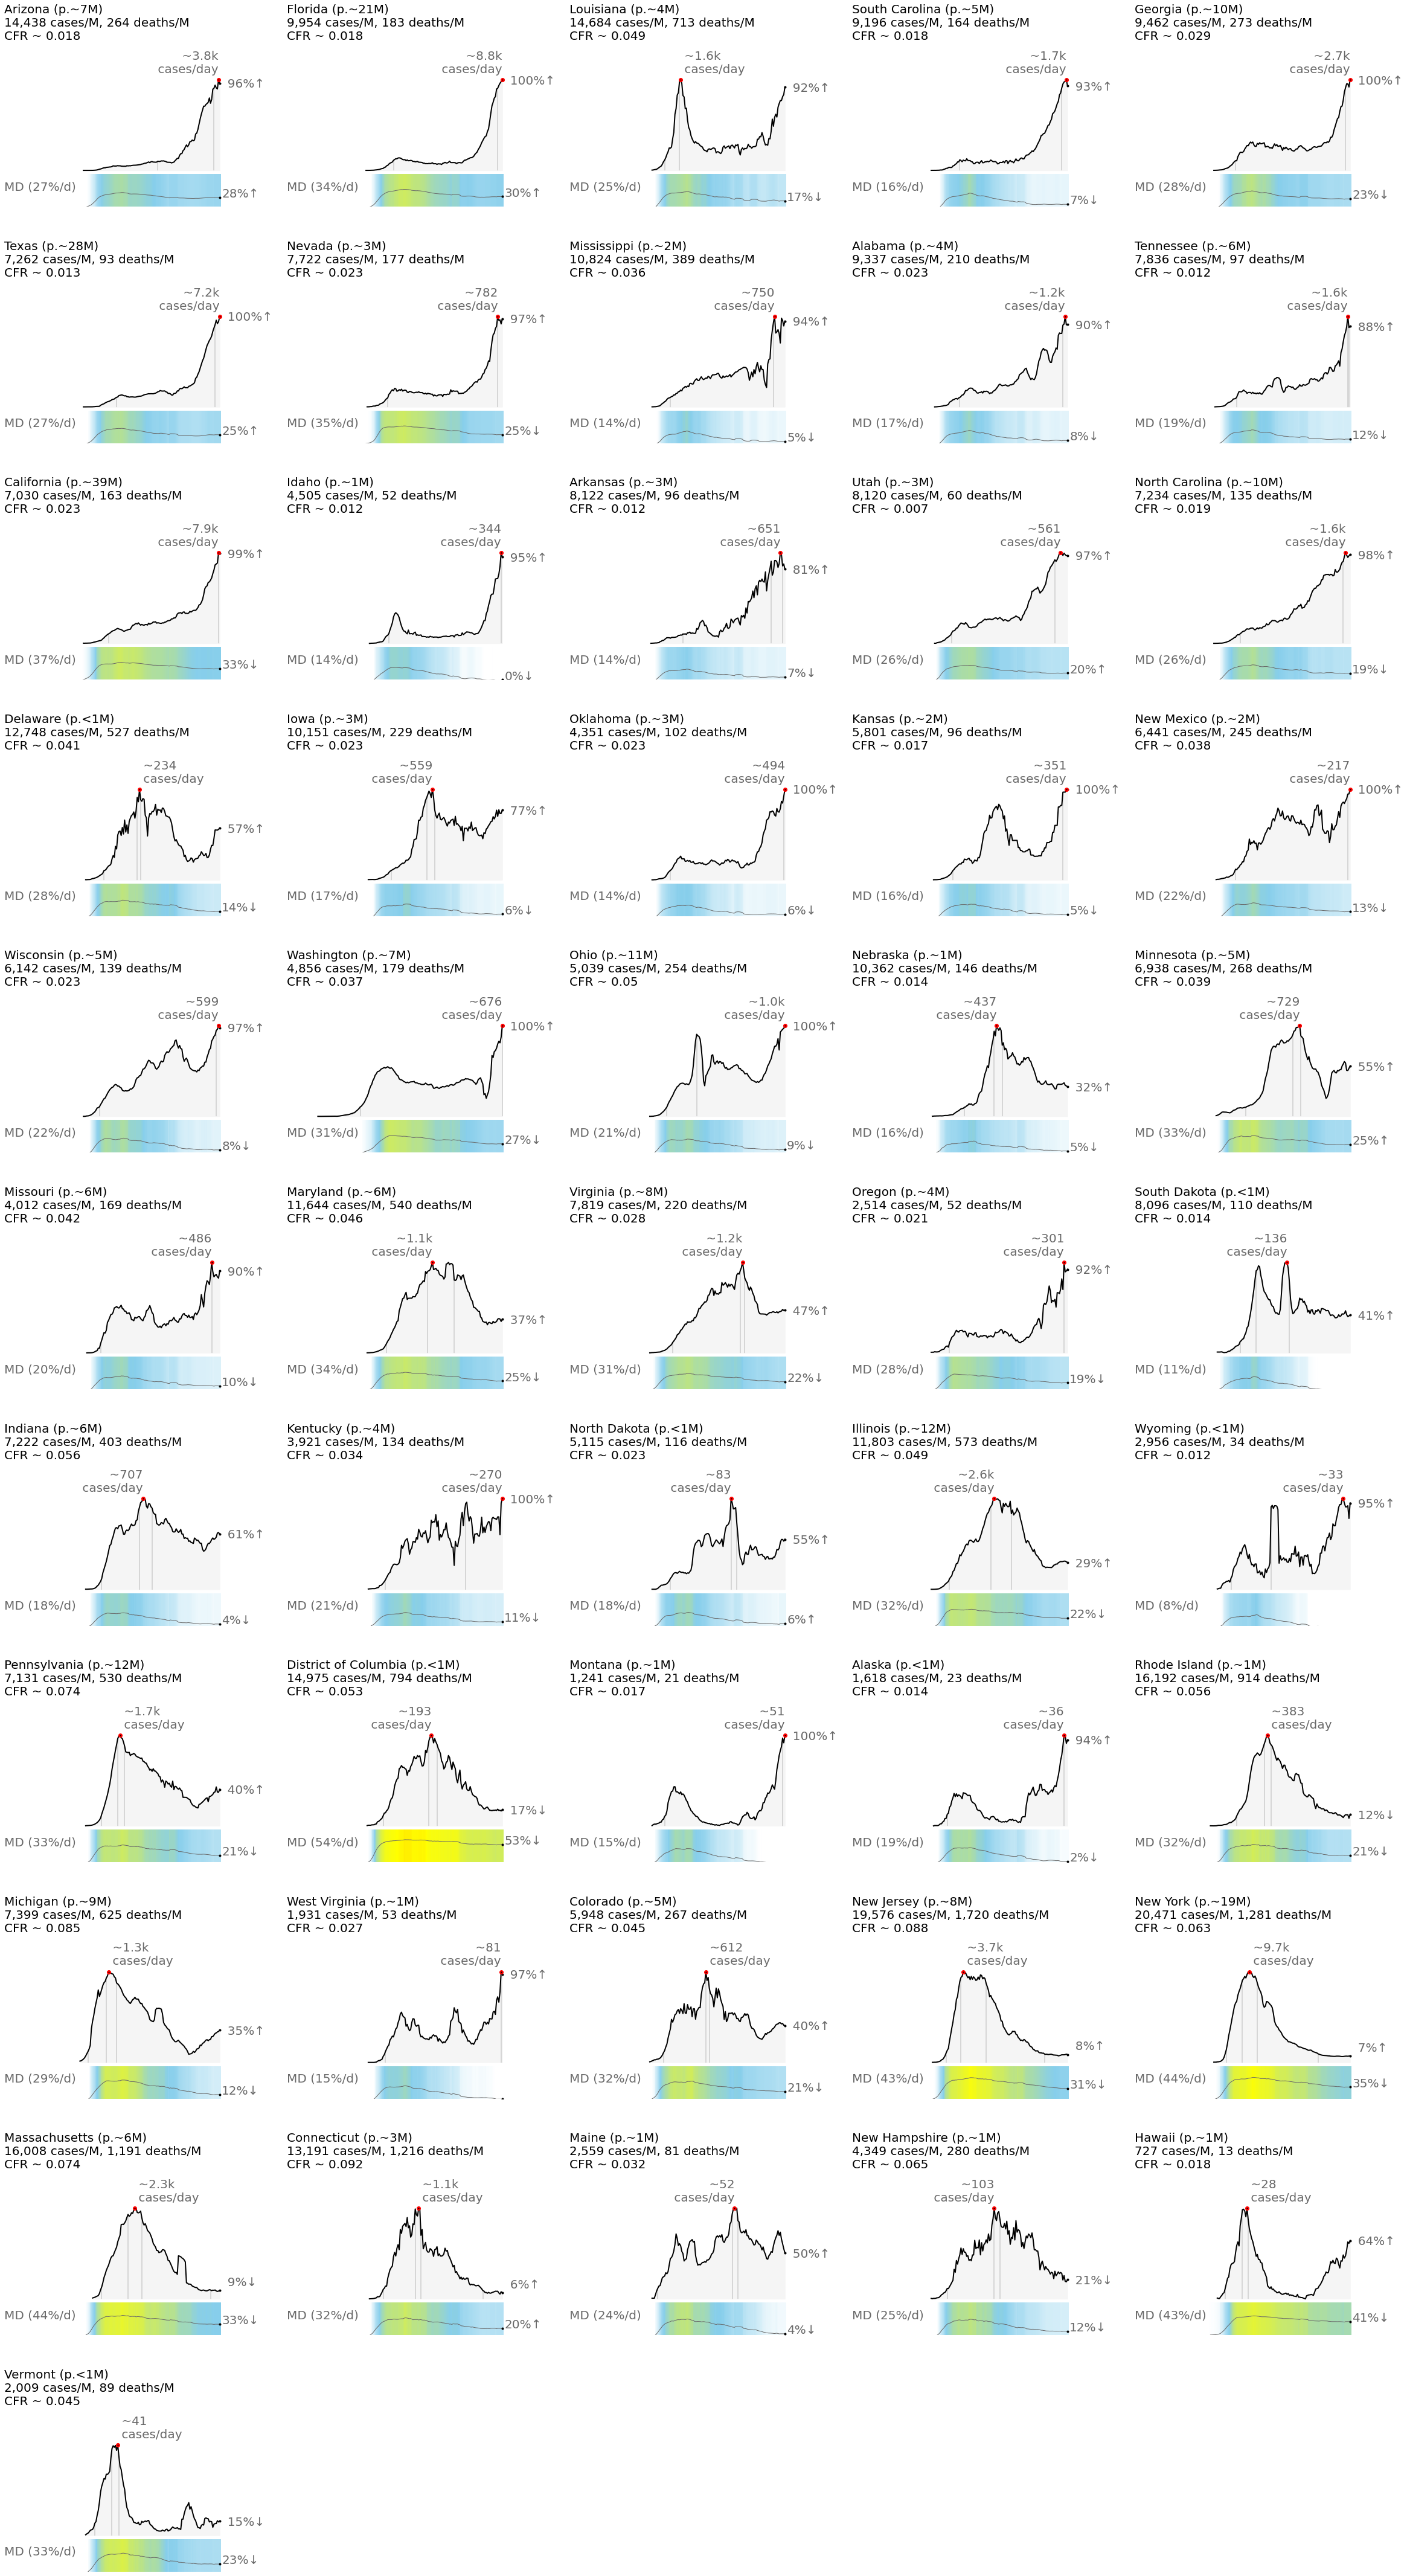

In [25]:
w, h = 8, 7
ncols, nrows = 5, 11

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': .45, 'wspace':.3})

for ax in axs.flatten(): ax.axis('off')

for state, ax in zip(sorted_states, axs.flatten()):
    
    data = df[df['state']==state].set_index('date')

    plot_peak_lockdown_model(ax, data, growth_col='new_cases_rolling_mean', fontsize=20)

fig.tight_layout()

fig.savefig('../graphs/peak_viz_for_states.png', format='png', dpi=200)